# Importing Libraries

In [1]:
import json
import re
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)
import matplotlib.pyplot as plt
%matplotlib inline
from pprint import pprint
from scipy import interp
from itertools import cycle
import seaborn as sns
from typing import List, Tuple


from tensorflow.python import keras
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D,Flatten,Dense, Dropout, Activation
from tensorflow.python.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.callbacks import EarlyStopping
from tensorflow.keras import metrics

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import gensim
from gensim.models import Word2Vec
import gensim.downloader as api


C:\Users\itsekouras\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# Importing Data

In [2]:
label2id = {
    'NEITHER': 0,
    'EVIDENCE': 1,
    'CLAIM': 2}

def load_corpus(path, label_mapping=label2id):
    with open(path) as fp:
        corpus = json.load(fp)

    documents, texts, labels = [], [], []
    for abstract in corpus:
        documents.append(abstract)
        texts.append(corpus[abstract]['sentences'])
        if isinstance(label_mapping, dict):
            labels.append(
                [label_mapping[str(l).upper()]
                    for l in corpus[abstract]['labels']])
        else:
            labels.append([str(l).upper() for l in corpus[abstract]['labels']])

    assert len(texts) == len(labels)
    data = pd.DataFrame(
        zip(documents, texts, labels),
        columns=['document', 'sentences', 'labels'])

    return data


In [3]:
data1 = load_corpus('/Users/itsekouras/Downloads/OneDrive_1_8-24-2021/dataset_aueb_argument_v3.json')

print(f'Dataset length: {len(data1)} abstracts')
data1.head()

Dataset length: 1017 abstracts


,document,sentences,labels
0,doi: 10.1001/jamaneurol.2017.2814,"[Concordance Between Different Amyloid Immunoassays and Visual Amyloid Positron Emission Tomographic Assessment, Importance Visual assessment of amyloid positron emission tomographic (PET) images has been approved by regulatory authorities for clinical use., Several immunoassays have been developed to measure β-amyloid (Aβ) 42 in cerebrospinal fluid (CSF)., The agreement between CSF Aβ42 measures from different immunoassays and visual PET readings may influence the use of CSF biomarkers and/or amyloid PET assessment in clinical practice and trials., Objective To determine the concordance between CSF Aβ42 levels measured using 5 different immunoassays and visual amyloid PET analysis., Design, Setting, and Participants The study included 262 patients with mild cognitive impairment or subjective cognitive decline from the Swedish BioFINDER (Biomarkers for Identifying Neurodegenerative Disorders Early and Reliably) cohort (recruited from September 1, 2010, through December 31, 2014) who had undergone flutemetamol F 18 ([18F]flutemetamol)–labeled PET., Levels of CSF Aβ42 were analyzed using the classic INNOTEST and the newer modified INNOTEST, fully automated Lumipulse (FL), EUROIMMUN (EI), and Meso Scale Discovery (MSD) assays., Concentrations of CSF Aβ were assessed using an antibody-independent mass spectrometry–based reference measurement procedure., Main Outcomes and Measures The concordance of CSF Aβ42 levels and Aβ42:Aβ40 and Aβ42:tau ratios with visual [18F]flutemetamol PET status., Results Of 262 participants (mean [SD] age, 70.9 [5.5] years), 108 were women (41.2%) and 154 were men (58.8%)., The mass spectrometry–derived Aβ42 values showed higher correlations with the modified Aβ42-INNOTEST (r = 0.97), Aβ42-FL (r = 0.93), Aβ42-EI (r = 0.93), and Aβ42-MSD (r = 0.95) assays compared with the classic Aβ42-INNOTEST assay (r = 0.88;P ≤ .01)., The signal in the classic Aβ42-INNOTEST assay was partly quenched by recombinant Aβ1-40 peptide., However, the classic Aβ42-INNOTEST assay showed better concordance with visual [18F]flutemetamol PET status (area under the receiver operating characteristic curve [AUC], 0.92) compared with the newer assays (AUCs, 0.87-0.89;P ≤ .01)., The accuracies of the newer assays improved significantly when Aβ42:Aβ40 (AUCs, 0.93-0.95;P ≤ .01), Aβ42 to total tau (T-tau) (AUCs, 0.94;P ≤ .05), or Aβ42 to phosphorylated tau (P-tau) (AUCs, 0.94-0.95;P ≤ .001) ratios were used., A combination of the Aβ42:Aβ40 ratio and T-tau or P-tau level did not improve the accuracy compared with the ratio alone., Conclusions and Relevance Concentrations of CSF Aβ42 derived from the new immunoassays (modified INNOTEST, FL, EI, and MSD) may correlate better with the antibody-independent mass spectrometry–based reference measurement procedure and may show improved agreement with visual [18F]flutemetamol PET assessment when using the Aβ42:Aβ40 or Aβ42:tau ratios., These findings suggest the benefit of implementing the CSF Aβ42:Aβ40 or Aβ42:tau ratios as a biomarker of amyloid deposition in clinical practice and trials.]","[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2]"
1,doi: 10.1001/jamaneurol.2017.4913,"[Association of Changes in Plasma Neurofilament Light and Tau Levels With Anesthesia and Surgery, Importance Anesthesia and surgery are believed to act on the central nervous system by a fully reversible mechanism innocuous to nerve cells., Evidence that neurological sequelae may follow would challenge this belief and would thereby suggest a need to reassess theories of the mechanism of anesthetic action or the response of the central nervous system to surgery., Objective To measure 2 biomarkers of neurological injury (neurofilament light and tau) in plasma in a series of timed collections before and after anesthesia and surgery., Design, Setting, and Participants These 2 related observational studies (CAPACITY and ARCADIAN) recruited patients 60 years and 

In [4]:
label2id2 = {
    'NONE': 0,
    'EVIDENCE': 1,
    'CLAIM': 2}


data2 = load_corpus('/Users/itsekouras/Downloads/OneDrive_1_8-24-2021/dataset.json',label_mapping=label2id2)

print(f'Dataset length: {len(data2)} abstracts')
data2.head(5)

Dataset length: 1669 abstracts


,document,sentences,labels
0,DEI_G2B1_15.txt,"[Gender Differences in Anxiety and Depression before and after Alcohol Detoxification: Anxiety and Depression as Gender-Related Predictors of Relapse, Abstract, Background/aims: The aim of this prospective study was to estimate gender differences in anxiety, depression, and alcohol use severity among patients with alcohol use disorder (AUD) before and after detoxification program and within 12 months after discharge., Methods: AUD severity, state and trait anxiety, and depression were assessed in 187 patients entering an inpatient alcohol detoxification program., Follow-up assessments were performed at 6 and 12 months after discharge., A between- and within-subjects analyses explored gender differences., The predictive value of anxiety and depression for alcohol relapse was analyzed by logistic and linear regression in both genders., Results: Females had higher levels of anxiety and depression than males both at admission and after discharge., Trait anxiety and depression significantly increased 6 months after discharge in males and females respectively., Both state and trait anxiety levels at the 6-month follow-up predicted alcohol relapse at the 12-month follow-up in males., Conversely, in females, depression level at the 6-month follow-up was a predictor of relapse at the 12-month follow-up., Conclusions: In both genders, the psychopathological dimension that showed the most significant worsening at 6-month follow-up (i.e., anxiety in males and depression in females) was found to be a significant predictor of relapse at the 12-month follow-up.]","[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2]"
1,DEI_G2B1_23.txt,"[Women's economic empowerment, participation in decision-making and exposure to violence as risk indicators for early childhood caries, Abstract, Objectives: In view of the association between early childhood caries (ECC])and maternal social risk factors, this study tried to determine if there were associations between indicators of processes, outputs and outcomes of women's empowerment, and the prevalence of ECC., Methods: In this ecological study, indicators measuring the explanatory variables - economic empowerment, decision-making and violence against women - were selected from the Integrated Results and Resources Framework of the UN-Women Strategic Plan 2018-2021 and WHO database., Indicators measuring the outcome variables - the prevalence of ECC for children aged 0 to 2 years, and 3 to 5 years - were extracted from a published literature., The general linear models used to determine the association between the outcome and explanatory variables were adjusted for economic level of countries., Regression estimates (B), 95% confidence intervals and partial eta squared (η2) were calculated., Results: Countries with more females living under 50% of median income had higher prevalence of ECC for 3 to 5-year olds (B = 1.82, 95% CI = 0.12, 3.52)., Countries with higher percentage of women participating in their own health care decisions had higher prevalence of ECC for 0 to 2-year-olds (B = 0.85, 95% CI = 0.03, 1.67)., Countries with higher percentage of women participating in decisions related to visiting family, relatives and friends had higher prevalence of ECC for 3 to 5-year-olds (B = 0.67, 95% CI = 0.03, 1.32)., None of the indicators for violence against women was significantly associated with the prevalence of ECC., Conclusion: Empowerment of women is a welcome social development that may have some negative impact on children's oral health., Changes in policies and norms are needed to protect children's oral health while empowering women.]","[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 2, 0]"
2,DEI_G2B1_24.txt,"[Forced sterilization of women as discrimination, Abstract, There has been a long history of subjecting marginalized women to forced and coerced sterilization., In recent years, the practice has been documented in countries in North and South America, Europe, Asia, and Africa., 

# Constructing the final dataset and providing some statitistics

In [6]:
data = pd.concat([data1,data2], ignore_index=True)
data.shape

(2686, 3)

In [7]:
data = data.drop_duplicates('document', keep='last')
data.shape

(2686, 3)

In [9]:
#title Split to sentences
sentences = data['sentences'].explode().reset_index().rename(
    columns={'index': 'doc_id', 'sentences': 'sentence'})
sentences

,doc_id,sentence
0,0,Concordance Between Different Amyloid Immunoassays and Visual Amyloid Positron Emission Tomographic Assessment
1,0,Importance Visual assessment of amyloid positron emission tomographic (PET) images has been approved by regulatory authorities for clinical use.
2,0,Several immunoassays have been developed to measure β-amyloid (Aβ) 42 in cerebrospinal fluid (CSF).
3,0,The agreement between CSF Aβ42 measures from different immunoassays and visual PET readings may influence the use of CSF biomarkers and/or amyloid PET assessment in clinical practice and trials.
4,0,Objective To determine the concordance between CSF Aβ42 levels measured using 5 different immunoassays and visual amyloid PET analysis.
...,...,...
31999,2685,No statistically significant difference in conjunctival hyperemia between the two latanoprost regimens was found (P = 0.37).
32000,2685,Latanoprost 0.005% once daily reduced IOP more effectively than latanoprost 0.0015% twice daily (P < 0.001).
32001,2685,Latanoprost had no statistically or clinically significant effect on the blood-aqueous barrier.
32002,2685,There was no difference in hyperemia between the two regimens.


In [10]:
#title and the corresponding labels
labels = data['labels'].explode().reset_index().rename(
    columns={'index': 'doc_id', 'labels': 'label'})
labels

,doc_id,label
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
31999,2685,1
32000,2685,0
32001,2685,2
32002,2685,2


In [11]:
df=pd.concat([sentences, labels['label']], axis=1)


In [12]:
df.head()

,doc_id,sentence,label
0,0,Concordance Between Different Amyloid Immunoassays and Visual Amyloid Positron Emission Tomographic Assessment,0
1,0,Importance Visual assessment of amyloid positron emission tomographic (PET) images has been approved by regulatory authorities for clinical use.,0
2,0,Several immunoassays have been developed to measure β-amyloid (Aβ) 42 in cerebrospinal fluid (CSF).,0
3,0,The agreement between CSF Aβ42 measures from different immunoassays and visual PET readings may influence the use of CSF biomarkers and/or amyloid PET assessment in clinical practice and trials.,0
4,0,Objective To determine the concordance between CSF Aβ42 levels measured using 5 different immunoassays and visual amyloid PET analysis.,0


In [13]:
data.isna().sum()

document     0
sentences    0
labels       0
dtype: int64

In [14]:
df.label.value_counts()

0    22375
1     6210
2     3419
Name: label, dtype: int64

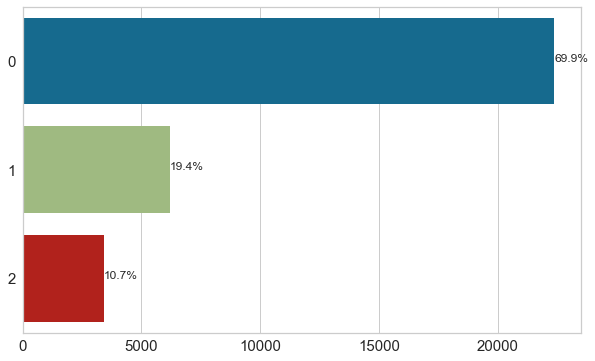

In [15]:
fig = plt.figure(figsize=(10,6))
ax = sns.countplot(y="label", data=df)
total = len(df)
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() 
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
ax.tick_params(labelsize=15)
ax.set_xlabel("")
ax.set_ylabel("")
plt.show()

# Baseline Model

In [17]:
claim_lexicon=['reveal', 'provide', 'confirm', 'suggest','Reveal', 'Provide', 'Confirm', 'Suggest',
             'in conclusion','In conclusion','conclusion','Conclusion','conclusions','Conclusions']

evidence_lexicon=['result','results','Result','Results','findings','Findings']

data['labels new'] = np.empty((len(data), 0)).tolist()

In [18]:
#Βρίσκω ποια και πόσα abstracts έχουν τις λέξεις του λεξικού μέσα.
lii=[]
for i in range(len(data)):
    for element in data.loc[i,'sentences']:
        if any(x in element for x in claim_lexicon):
            data.loc[i,'labels new'].append(2)
        elif any(x in element for x in evidence_lexicon):
            data.loc[i,'labels new'].append(1)
        else:
            data.loc[i,'labels new'].append(0) 

In [19]:
#κάθε τελευταία πρόταση την ονομάζω claim
for i in range(len(data)):
      data.loc[i,'labels new'][-1]=2

In [21]:
#Βρίσκω similarities στα claim συνολικά
claim_true_pos=0
evidence_true_pos=0
claim_false_neg=0
evidence_false_neg=0
claim_false_pos=0
evidence_false_pos=0
for i in range(len(data)):
    for size in range(len(data.loc[i,'labels'])):
        if data.loc[i,'labels new'][size]==2 and data.loc[i,'labels'][size]==2:
            claim_true_pos+=1
        if data.loc[i,'labels new'][size]!=2 and data.loc[i,'labels'][size]==2:
            claim_false_neg+=1
        if data.loc[i,'labels new'][size]==2 and data.loc[i,'labels'][size]!=2:
            claim_false_pos+=1
        if data.loc[i,'labels new'][size]==1 and data.loc[i,'labels'][size]==1:
            evidence_true_pos+=1
        if data.loc[i,'labels new'][size]!=1 and data.loc[i,'labels'][size]==1:
            evidence_false_neg+=1   
        if data.loc[i,'labels new'][size]==1 and data.loc[i,'labels'][size]!=1:
            evidence_false_pos+=1

In [22]:
claim_recall=claim_true_pos/(claim_true_pos+claim_false_neg)#recall
claim_recall

0.5949107926294238

In [23]:
claim_precision=claim_true_pos/(claim_true_pos+claim_false_pos)#precision
claim_precision

0.4708333333333333

In [24]:
evidence_recall=evidence_true_pos/(evidence_true_pos+evidence_false_neg)#recall
evidence_recall

0.08486312399355878

In [25]:
evidence_precision=evidence_true_pos/(evidence_true_pos+evidence_false_pos)#precision
evidence_precision

0.33396704689480355

In [26]:
#F-Score claim F-Measure = (2 * Precision * Recall) / (Precision + Recall)

#claim
claim_F_score = (2*claim_recall*claim_precision)/(claim_recall+claim_precision)
print(claim_F_score)


#evidence
evidence_F_score = (2*evidence_recall*evidence_precision)/(evidence_recall+evidence_precision)
print(evidence_F_score)


0.525649308696214
0.13533641499743193


# Prepossesing Data

In [28]:
en_stop = stopwords.words('english')

In [29]:
lmtzr = WordNetLemmatizer()

In [30]:
def clean_sentence(val):
    "remove chars that are not letters or numbers, downcase, then remove stop words"
    regex = re.compile('([^\s\w]|_)+')
    sentence = regex.sub('', val).lower()
    sentence = sentence.split(" ")      
    sentence = [word for word in sentence if not word in en_stop]
    sentence = [lmtzr.lemmatize(word,pos='v') for word in sentence ] 
    sentence = [lmtzr.lemmatize(word) for word in sentence ]
    sentence = [i for i in sentence if not i.isdigit()]
    sentence = " ".join(sentence)
    return sentence

In [31]:
df["clean_sen"]=df["sentence"].apply(clean_sentence)

In [33]:
df.head()

,doc_id,sentence,label,clean_sen
0,0,Concordance Between Different Amyloid Immunoassays and Visual Amyloid Positron Emission Tomographic Assessment,0,concordance different amyloid immunoassay visual amyloid positron emission tomographic assessment
1,0,Importance Visual assessment of amyloid positron emission tomographic (PET) images has been approved by regulatory authorities for clinical use.,0,importance visual assessment amyloid positron emission tomographic pet image approve regulatory authority clinical use
2,0,Several immunoassays have been developed to measure β-amyloid (Aβ) 42 in cerebrospinal fluid (CSF).,0,several immunoassay develop measure βamyloid aβ cerebrospinal fluid csf
3,0,The agreement between CSF Aβ42 measures from different immunoassays and visual PET readings may influence the use of CSF biomarkers and/or amyloid PET assessment in clinical practice and trials.,0,agreement csf aβ42 measure different immunoassay visual pet read may influence use csf biomarkers andor amyloid pet assessment clinical practice trial
4,0,Objective To determine the concordance between CSF Aβ42 levels measured using 5 different immunoassays and visual amyloid PET analysis.,0,objective determine concordance csf aβ42 level measure use different immunoassay visual amyloid pet analysis


In [34]:
X = df['clean_sen'].values
y= df['label']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=y)

In [36]:
nb_classes=3

In [37]:
y_train = to_categorical(y_train, nb_classes)

y_test = to_categorical(y_test, nb_classes)


print('Y_train shape:', y_train.shape)

print('Y_test shape:', y_test.shape)


Y_train shape: (22402, 3)
Y_test shape: (9602, 3)


In [38]:
tokenizer = Tokenizer(num_words=15000)
tokenizer.fit_on_texts(X_train)

X_train_s = tokenizer.texts_to_sequences(X_train)
X_test_s = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(vocab_size)
print(X_train_s[0])
print(X_train[0])

23197
[2001, 777, 2056, 1164, 511, 42, 344, 4973, 21, 117, 5586, 1164, 117, 9246, 117]
hcc diagnose regular surveillance define mean interval ultrasonography month n  irregular surveillance n  nonsurveillance n 


In [39]:
print('Train sequences: {}'.format(len(X_train_s)))
print('Test sequences: {}'.format(len(X_test_s)))

Train sequences: 22402
Test sequences: 9602


In [40]:
maxlen=50

In [41]:
x_train = sequence.pad_sequences(X_train_s,
                                 maxlen=maxlen,
                                 padding='post',
                                 truncating='post',
                                 value=0.0)

x_test = sequence.pad_sequences(X_test_s,
                                maxlen=maxlen,
                                 padding='post',
                                 truncating='post',
                                 value=0.0)


In [42]:
print('x_train shape: {}'.format(x_train.shape))
print('x_test shape: {}'.format(x_test.shape))

x_train shape: (22402, 50)
x_test shape: (9602, 50)


In [43]:

embedding_dims = 100

nof_filters = 32

kernel_size = 3

hidden_dims = 50

# Models for Text Classification and Evaluation of them

Fist Model

In [44]:
model = Sequential()

model.add(Embedding(vocab_size,
                    embedding_dims,
                    input_length=maxlen))

model.add(Dropout(0.2))

model.add(Conv1D(nof_filters, 
                 kernel_size, 
                 padding='valid',
                 activation='relu',
                 strides=1))

model.add(GlobalMaxPooling1D())

model.add(Dense(hidden_dims))

model.add(Dropout(0.2))
model.add(Activation('relu'))

model.add(Dense(nb_classes))
model.add(Activation('softmax'))

In [45]:
print( model.summary() )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           2319700   
_________________________________________________________________
dropout (Dropout)            (None, 50, 100)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 48, 32)            9632      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                1650      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
activation (Activation)      (None, 50)                0

In [46]:
model.compile(
    loss='categorical_crossentropy',  
    optimizer='adam',
    metrics=[metrics.mae,
        metrics.categorical_accuracy]
)

In [47]:

batch_size = 128
epochs = 100

In [48]:

# early stopping callback

es = keras.callbacks.EarlyStopping(
    monitor   = 'val_loss', # which metric we want to use as criterion to stop training
    min_delta = 0, # Minimum change in the monitored quantity to qualify as an improvement
    patience  = 4, # we 3 epochs before stopping
    verbose   = 1, # verbosity level
    mode      = 'auto',
    restore_best_weights = True
)

In [49]:
history = model.fit(
    x_train,              # features
    y_train,                # labels
    epochs=epochs,          # numbers of epoch
    batch_size=batch_size,  # define batch size
    verbose=1,              # the most extended verbose
    validation_split=0.15 ,   # 85% for train and 15% for validation
    callbacks=[es]
)


Epoch 1/100
149/149 [==============================] - 10s 58ms/step - loss: 0.7914 - mean_absolute_error: 0.3094 - categorical_accuracy: 0.7028 - val_loss: 0.6572 - val_mean_absolute_error: 0.2530 - val_categorical_accuracy: 0.7459
Epoch 2/100
149/149 [==============================] - 9s 58ms/step - loss: 0.5713 - mean_absolute_error: 0.2177 - categorical_accuracy: 0.7775 - val_loss: 0.5845 - val_mean_absolute_error: 0.2246 - val_categorical_accuracy: 0.7655
Epoch 3/100
149/149 [==============================] - 9s 59ms/step - loss: 0.4138 - mean_absolute_error: 0.1611 - categorical_accuracy: 0.8430 - val_loss: 0.6014 - val_mean_absolute_error: 0.2037 - val_categorical_accuracy: 0.7611
Epoch 4/100
149/149 [==============================] - 9s 63ms/step - loss: 0.2767 - mean_absolute_error: 0.1087 - categorical_accuracy: 0.9027 - val_loss: 0.6742 - val_mean_absolute_error: 0.1914 - val_categorical_accuracy: 0.7513
Epoch 5/100
149/149 [==============================] - 9s 62ms/step - l

In [50]:
def plot_keras_history(history):
    """
    
    :param history: 
    :return: 
    """
    # the history object gives the metrics keys. 
    # we will store the metrics keys that are from the training sesion.
    metrics_names = [key for key in history.history.keys() if not key.startswith('val_')]

    for i, metric in enumerate(metrics_names):
        
        # getting the training values
        metric_train_values = history.history.get(metric, [])
        
        # getting the validation values
        metric_val_values = history.history.get("val_{}".format(metric), [])

        # As loss always exists as a metric we use it to find the 
        epochs = range(1, len(metric_train_values) + 1)
        
        # leaving extra spaces to allign with the validation text
        training_text = "   Training {}: {:.5f}".format(metric,
                                                        metric_train_values[-1])

        # metric
        plt.figure(i, figsize=(12, 6))

        plt.plot(epochs,
                 metric_train_values,
                 'b',
                 label=training_text)
        
        # if we validation metric exists, then plot that as well
        if metric_val_values:
            validation_text = "Validation {}: {:.5f}".format(metric,
                                                             metric_val_values[-1])

            plt.plot(epochs,
                     metric_val_values,
                     'g',
                     label=validation_text)
        
        # add title, xlabel, ylabe, and legend
        plt.title('Model Metric: {}'.format(metric))
        plt.xlabel('Epochs')
        plt.ylabel(metric.title())
        plt.legend()

    plt.show()

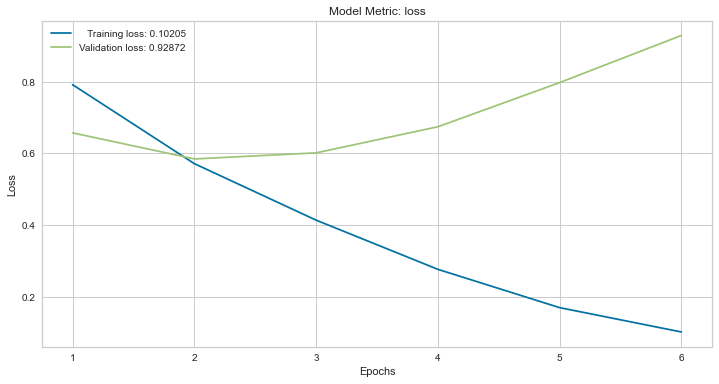

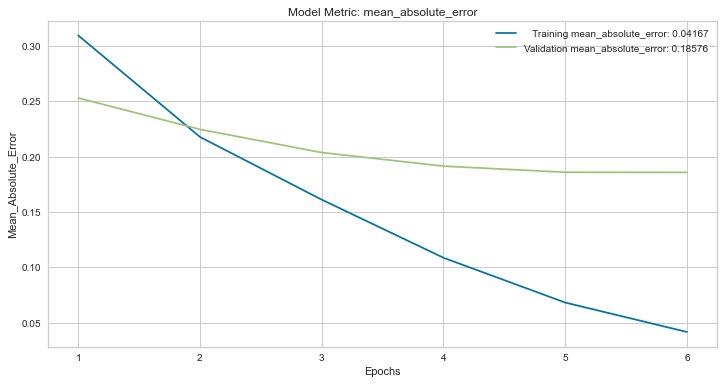

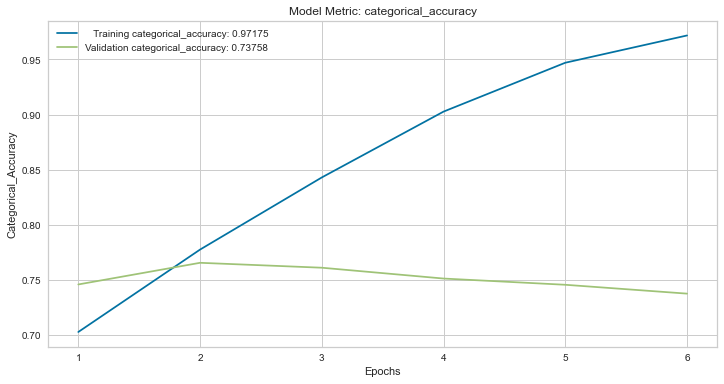

In [51]:
plot_keras_history(history)

In [52]:
score = model.evaluate(
    x_test,                  # features
    y_test,                  # labels
    batch_size=batch_size,   # batch size
    verbose=1                # the most extended verbose
)


print('\nTest categorical_crossentropy:', score[0])
print('\nTest mean_absolute_error:', score[1])
print('\nTest accuracy: {:.3f} %'.format(score[2]*100))

76/76 [==============================] - 0s 3ms/step - loss: 0.5828 - mean_absolute_error: 0.2261 - categorical_accuracy: 0.7667

Test categorical_crossentropy: 0.5827710628509521

Test mean_absolute_error: 0.22611454129219055

Test accuracy: 76.672 %


In [53]:
y_test_pred = model.predict_classes(x_test)

C:\Users\itsekouras\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [54]:
conf_mat = confusion_matrix(y_test.argmax(axis=1),
                            y_test_pred)

pd.DataFrame(conf_mat)

,0,1,2
0,6094,491,128
1,797,1018,48
2,594,182,250


In [55]:
print(classification_report(y_test.argmax(axis=1),
                            y_test_pred,
                            digits=4))

              precision    recall  f1-score   support

           0     0.8142    0.9078    0.8584      6713
           1     0.6020    0.5464    0.5729      1863
           2     0.5869    0.2437    0.3444      1026

    accuracy                         0.7667      9602
   macro avg     0.6677    0.5660    0.5919      9602
weighted avg     0.7487    0.7667    0.7481      9602



In [56]:
def plot_multi_class_roc_auc_curves(nb_classes, y_true, y_pred_score, lw: int = 2):
    """
    ROC, AUC for a categorical classifier
    
    ROC curve extends to problems with three or more classes with what is known as the one-vs-all approach.
    For instance, if we have three classes, we will create three ROC curves,

    For each class, we take it as the positive class and group the rest classes jointly as the negative class.

    Class 1 vs classes 2&3
    Class 2 vs classes 1&3
    Class 3 vs classes 1&2

    :param nb_classes:
    :param y_true:
    :param y_pred_score:
    :param lw:
    :return:
    """

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(nb_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_score[:, i])

        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred_score.ravel())

    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(nb_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(nb_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= nb_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(1)
    plt.plot(fpr["micro"],
             tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
             color='deeppink',
             linestyle=':',
             linewidth=4)

    plt.plot(fpr["macro"],
             tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
             color='navy',
             linestyle=':',
             linewidth=4)

    colors = cycle(['aqua',
                    'darkorange',
                    'cornflowerblue'])

    for i, color in zip(range(nb_classes), colors):
        plt.plot(fpr[i],
                 tpr[i],
                 color=color,
                 lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1],
             [0, 1],
             'k--',
             lw=lw)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")



In [57]:
y_score = model.predict(x_test)

<ipython-input-56-5e34eafa2961>:45: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


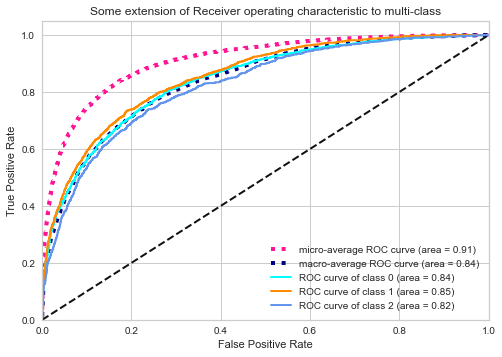

In [58]:
plot_multi_class_roc_auc_curves(nb_classes=nb_classes,
                                y_true=y_test,
                                y_pred_score=y_score)

Second Model with pre-trainned embeddings

In [62]:
embeddings_index = dict()
f = open('C:/Users/itsekouras/Downloads/glove.6B/glove.6B.300d.txt', encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [63]:
embedding_matrix = np.zeros((vocab_size, 300))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [64]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.5681769194292365

In [65]:
model2 = Sequential()

model2.add(Embedding(vocab_size,
                    300,
                    weights=[embedding_matrix],
                    input_length=maxlen,
                    trainable=True))

model2.add(Dropout(0.2))

model2.add(Conv1D(nof_filters, 
                 kernel_size, 
                 padding='valid',
                 activation='relu',
                 strides=1))

model2.add(GlobalMaxPooling1D())

model2.add(Dense(hidden_dims))

model2.add(Dropout(0.2))
model.add(Activation('relu'))

model2.add(Dense(nb_classes))
model2.add(Activation('softmax'))

In [66]:
print( model2.summary() )

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 300)           6959100   
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 300)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 48, 32)            28832     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                1650      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                

In [67]:
model2.compile(
    loss='categorical_crossentropy',  
    optimizer='adam',
    metrics=[metrics.mae,
        metrics.categorical_accuracy]
)

In [68]:
history = model2.fit(
    x_train,              # features
    y_train,                # labels
    epochs=epochs,          # numbers of epoch
    batch_size=batch_size,  # define batch size
    verbose=1,              # the most extended verbose
    validation_split=0.15 ,   # 85% for train and 15% for validation
    callbacks=[es]
)


Epoch 1/100
149/149 [==============================] - 26s 167ms/step - loss: 0.7274 - mean_absolute_error: 0.2691 - categorical_accuracy: 0.7263 - val_loss: 0.6353 - val_mean_absolute_error: 0.2501 - val_categorical_accuracy: 0.7480
Epoch 2/100
149/149 [==============================] - 26s 174ms/step - loss: 0.5707 - mean_absolute_error: 0.2157 - categorical_accuracy: 0.7741 - val_loss: 0.5862 - val_mean_absolute_error: 0.2091 - val_categorical_accuracy: 0.7629
Epoch 3/100
149/149 [==============================] - 26s 177ms/step - loss: 0.4714 - mean_absolute_error: 0.1801 - categorical_accuracy: 0.8146 - val_loss: 0.5917 - val_mean_absolute_error: 0.2072 - val_categorical_accuracy: 0.7611
Epoch 4/100
149/149 [==============================] - 23s 157ms/step - loss: 0.3762 - mean_absolute_error: 0.1459 - categorical_accuracy: 0.8552 - val_loss: 0.6372 - val_mean_absolute_error: 0.1946 - val_categorical_accuracy: 0.7563
Epoch 5/100
149/149 [==============================] - 24s 162ms

In [69]:
def plot_keras_history(history):
    """
    
    :param history: 
    :return: 
    """
    # the history object gives the metrics keys. 
    # we will store the metrics keys that are from the training sesion.
    metrics_names = [key for key in history.history.keys() if not key.startswith('val_')]

    for i, metric in enumerate(metrics_names):
        
        # getting the training values
        metric_train_values = history.history.get(metric, [])
        
        # getting the validation values
        metric_val_values = history.history.get("val_{}".format(metric), [])

        # As loss always exists as a metric we use it to find the 
        epochs = range(1, len(metric_train_values) + 1)
        
        # leaving extra spaces to allign with the validation text
        training_text = "   Training {}: {:.5f}".format(metric,
                                                        metric_train_values[-1])

        # metric
        plt.figure(i, figsize=(12, 6))

        plt.plot(epochs,
                 metric_train_values,
                 'b',
                 label=training_text)
        
        # if we validation metric exists, then plot that as well
        if metric_val_values:
            validation_text = "Validation {}: {:.5f}".format(metric,
                                                             metric_val_values[-1])

            plt.plot(epochs,
                     metric_val_values,
                     'g',
                     label=validation_text)
        
        # add title, xlabel, ylabe, and legend
        plt.title('Model Metric: {}'.format(metric))
        plt.xlabel('Epochs')
        plt.ylabel(metric.title())
        plt.legend()

    plt.show()

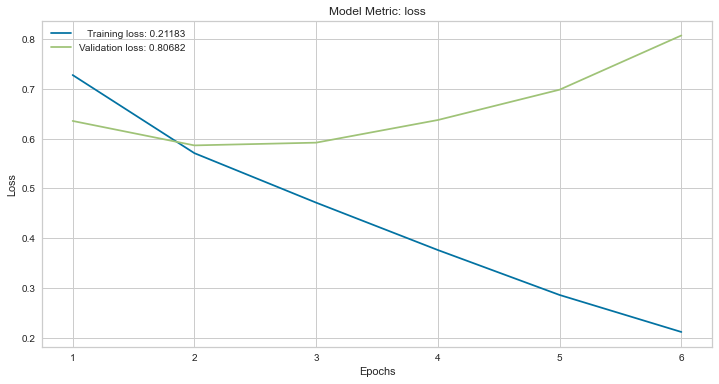

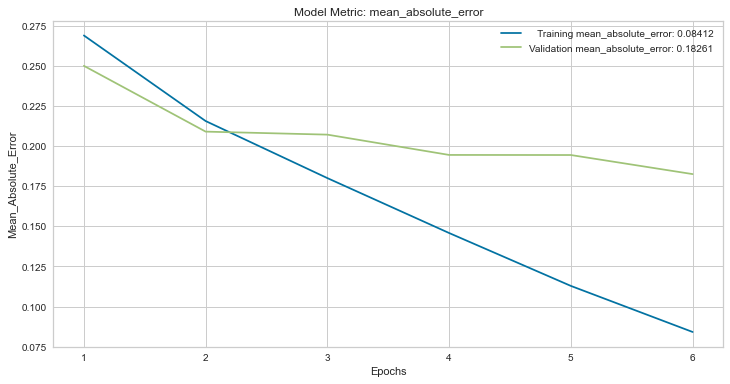

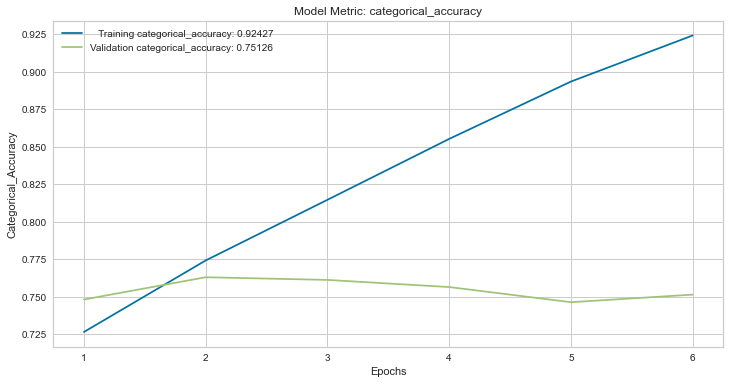

In [70]:
plot_keras_history(history)

In [71]:
score = model2.evaluate(
    x_test,                  # features
    y_test,                  # labels
    batch_size=batch_size,   # batch size
    verbose=1                # the most extended verbose
)


print('\nTest categorical_crossentropy:', score[0])
print('\nTest mean_absolute_error:', score[1])
print('\nTest accuracy: {:.3f} %'.format(score[2]*100))

76/76 [==============================] - 1s 8ms/step - loss: 0.5797 - mean_absolute_error: 0.2079 - categorical_accuracy: 0.7692

Test categorical_crossentropy: 0.5796535611152649

Test mean_absolute_error: 0.20791852474212646

Test accuracy: 76.921 %


In [72]:
y_test_pred = model2.predict_classes(x_test)

C:\Users\itsekouras\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [73]:
conf_mat = confusion_matrix(y_test.argmax(axis=1),
                            y_test_pred)

pd.DataFrame(conf_mat)

,0,1,2
0,6304,284,125
1,994,820,49
2,666,98,262


In [74]:
print(classification_report(y_test.argmax(axis=1),
                            y_test_pred,
                            digits=4))

              precision    recall  f1-score   support

           0     0.7916    0.9391    0.8590      6713
           1     0.6822    0.4402    0.5351      1863
           2     0.6009    0.2554    0.3584      1026

    accuracy                         0.7692      9602
   macro avg     0.6916    0.5449    0.5842      9602
weighted avg     0.7500    0.7692    0.7427      9602



In [75]:
def plot_multi_class_roc_auc_curves(nb_classes, y_true, y_pred_score, lw: int = 2):
    """
    ROC, AUC for a categorical classifier
    
    ROC curve extends to problems with three or more classes with what is known as the one-vs-all approach.
    For instance, if we have three classes, we will create three ROC curves,

    For each class, we take it as the positive class and group the rest classes jointly as the negative class.

    Class 1 vs classes 2&3
    Class 2 vs classes 1&3
    Class 3 vs classes 1&2

    :param nb_classes:
    :param y_true:
    :param y_pred_score:
    :param lw:
    :return:
    """

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(nb_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_score[:, i])

        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred_score.ravel())

    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(nb_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(nb_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= nb_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(1)
    plt.plot(fpr["micro"],
             tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),
             color='deeppink',
             linestyle=':',
             linewidth=4)

    plt.plot(fpr["macro"],
             tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),
             color='navy',
             linestyle=':',
             linewidth=4)

    colors = cycle(['aqua',
                    'darkorange',
                    'cornflowerblue'])

    for i, color in zip(range(nb_classes), colors):
        plt.plot(fpr[i],
                 tpr[i],
                 color=color,
                 lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1],
             [0, 1],
             'k--',
             lw=lw)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")



In [76]:
y_score = model2.predict(x_test)

<ipython-input-75-5e34eafa2961>:45: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


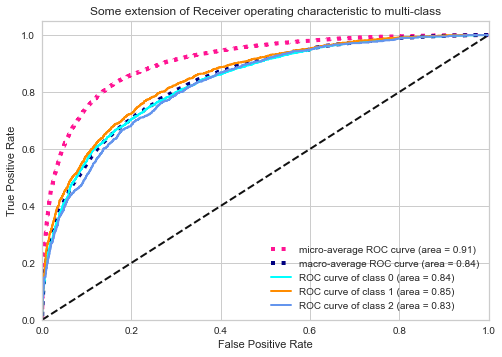

In [77]:
plot_multi_class_roc_auc_curves(nb_classes=nb_classes,
                                y_true=y_test,
                                y_pred_score=y_score)

In [78]:
model.save('first_model.h5')
model2.save('best_model.h5')

In [79]:
from sklearn.dummy import DummyClassifier

dummy_classifier = DummyClassifier(strategy='most_frequent')
dummy_classifier.fit(x_train, y_train)
y_dummy_pred = dummy_classifier.predict(x_test)
print(classification_report(y_test, y_dummy_pred,digits=4,zero_division=1))

              precision    recall  f1-score   support

           0     0.6991    1.0000    0.8229      6713
           1     1.0000    0.0000    0.0000      1863
           2     1.0000    0.0000    0.0000      1026

   micro avg     0.6991    0.6991    0.6991      9602
   macro avg     0.8997    0.3333    0.2743      9602
weighted avg     0.7897    0.6991    0.5753      9602
 samples avg     0.6991    0.6991    0.6991      9602



# Documents Clustering 

Claim Clustering with a wor2vec model and glove model

In [80]:
df_cl=df.loc[df['label'] == 2]
df_cl

,doc_id,sentence,label,clean_sen
15,0,"Conclusions and Relevance Concentrations of CSF Aβ42 derived from the new immunoassays (modified INNOTEST, FL, EI, and MSD) may correlate better with the antibody-independent mass spectrometry–based reference measurement procedure and may show improved agreement with visual [18F]flutemetamol PET assessment when using the Aβ42:Aβ40 or Aβ42:tau ratios.",2,conclusion relevance concentration csf aβ42 derive new immunoassay modify innotest fl ei msd may correlate better antibodyindependent mass spectrometrybased reference measurement procedure may show improve agreement visual 18fflutemetamol pet assessment use aβ42aβ40 aβ42tau ratio
16,0,These findings suggest the benefit of implementing the CSF Aβ42:Aβ40 or Aβ42:tau ratios as a biomarker of amyloid deposition in clinical practice and trials.,2,find suggest benefit implement csf aβ42aβ40 aβ42tau ratio biomarker amyloid deposition clinical practice trial
30,1,The increases in both neurofilament light and tau over 48 hours after surgery suggest that general anesthesia and surgery may be associated with neuronal damage in the short term.,2,increase neurofilament light tau hour surgery suggest general anesthesia surgery may associate neuronal damage short term
31,1,Further investigations will be required to study any association with clinical outcomes.,2,investigation require study association clinical outcome
32,1,"These preliminary findings demand that we question the prevailing assumption that anesthesia and surgery are innocuous, transient, and without injurious changes to the central nervous system.",2,preliminary find demand question prevail assumption anesthesia surgery innocuous transient without injurious change central nervous system
...,...,...,...,...
31976,2683,"Because the efficacy of both drugs was equivalent, with an identical safety profile, the long-acting eye drops seem to be an efficacious formulation for clinical use in Japanese glaucoma patients.",2,efficacy drug equivalent identical safety profile longacting eye drop seem efficacious formulation clinical use japanese glaucoma patient
31988,2684,Our study suggests that intraoperative topical 5-FU is at least as effective as intraoperative topical MMC in reducing IOP of eyes undergoing primary trabeculectomy.,2,study suggest intraoperative topical 5fu least effective intraoperative topical mmc reduce iop eye undergo primary trabeculectomy
32001,2685,Latanoprost had no statistically or clinically significant effect on the blood-aqueous barrier.,2,latanoprost statistically clinically significant effect bloodaqueous barrier
32002,2685,There was no difference in hyperemia between the two regimens.,2,difference hyperemia two regimen


In [81]:
tokenized_claim=df["clean_sen"].apply(word_tokenize)
claim=list(tokenized_claim)

In [82]:
glove_model= api.load('glove-wiki-gigaword-300')

In [84]:
model_t= Word2Vec(claim, min_count=1)

In [85]:
def vectorize(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding

    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features
    


In [86]:
def vectorize_pretrained(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding

    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model:
                try:
                    vectors.append(model[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features

In [87]:
vectorized_claim = vectorize(claim, model=model_t)
len(vectorized_claim), len(vectorized_claim[0])

(32004, 100)

In [88]:
X=np.array(vectorized_claim)

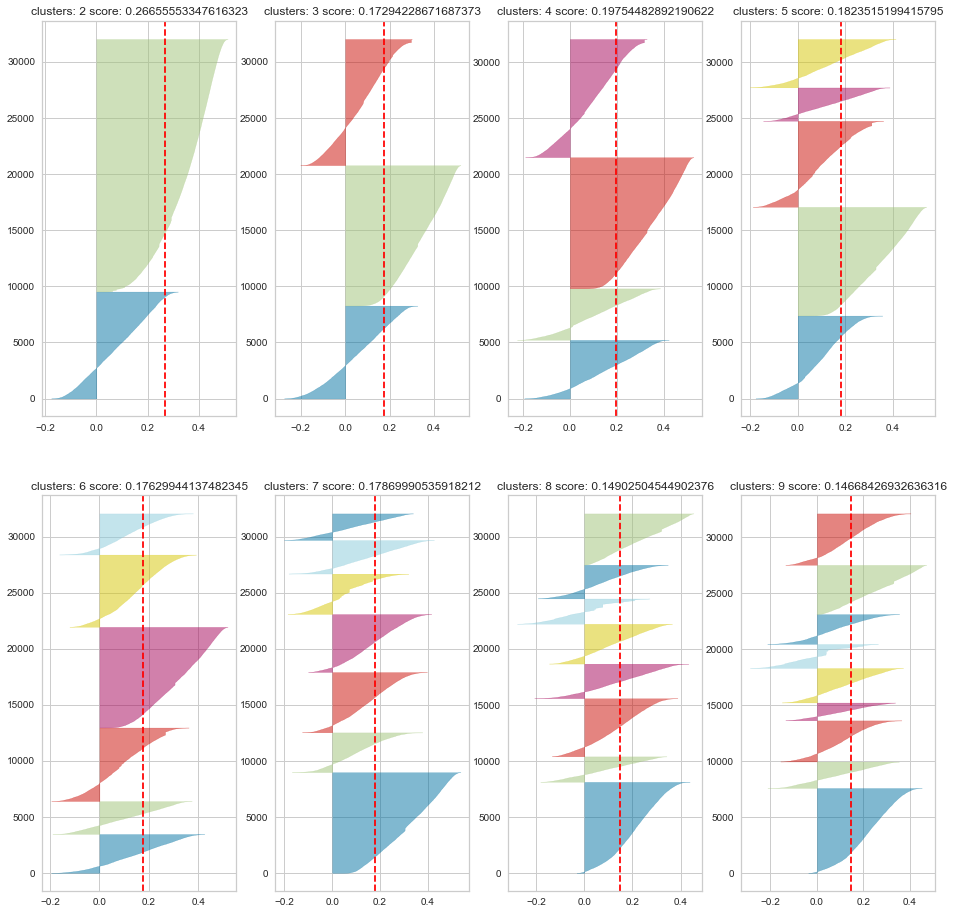

In [89]:
plt.figure(figsize=(4 * 4,  2 * 8))

scores = {}
for n_clusters in range(2,10):
    plt.subplot(2, 4, n_clusters - 1)
    kmeans = KMeans(n_clusters, random_state=42)
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
    visualizer.fit(X)
    scores[n_clusters] = visualizer.silhouette_score_
    plt.title(f'clusters: {n_clusters} score: {visualizer.silhouette_score_}')

In [90]:
sorted(scores.items(), key=lambda kv: kv[1], reverse=True)

[(2, 0.26655553347616323),
 (4, 0.19754482892190622),
 (5, 0.1823515199415795),
 (7, 0.17869990535918212),
 (6, 0.17629944137482345),
 (3, 0.17294228671687373),
 (8, 0.14902504544902376),
 (9, 0.14668426932636316)]

In [91]:
vectorized_claim = vectorize_pretrained(claim, model=glove_model)
len(vectorized_claim), len(vectorized_claim[0])

(32004, 300)

In [92]:
X=np.array(vectorized_claim)

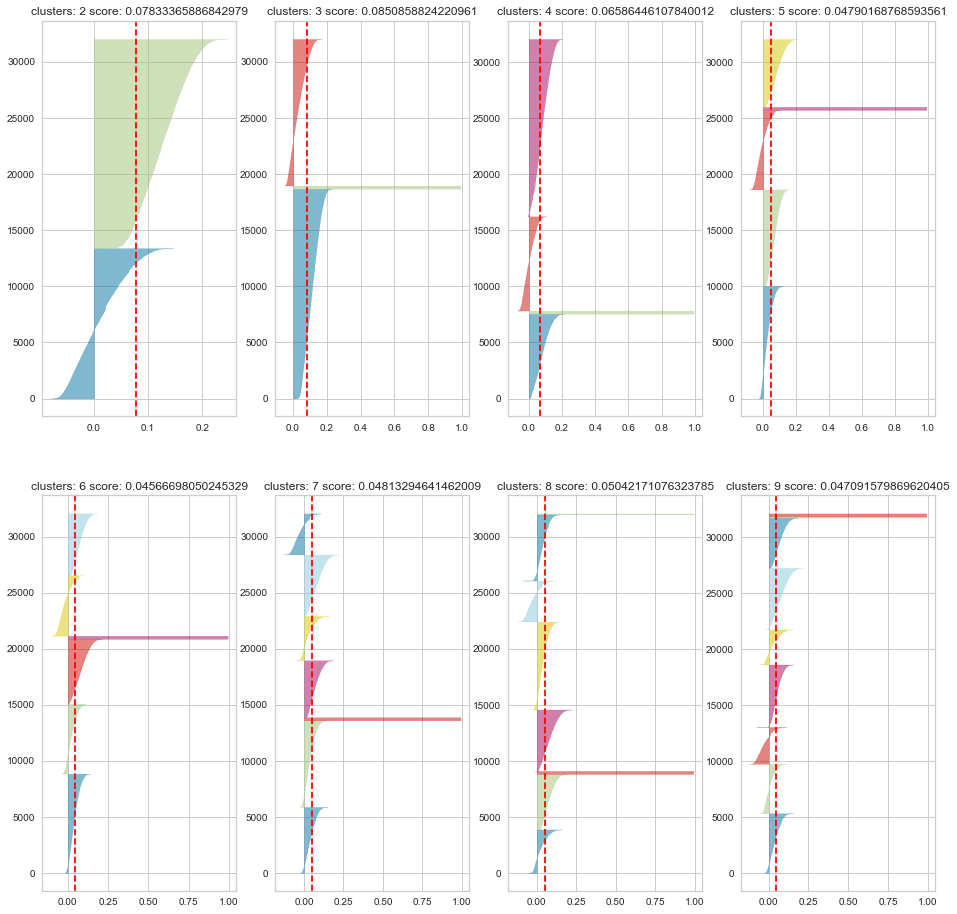

In [93]:
plt.figure(figsize=(4 * 4,  2 * 8))

scores = {}
for n_clusters in range(2,10):
    plt.subplot(2, 4, n_clusters - 1)
    kmeans = KMeans(n_clusters, random_state=42)
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
    visualizer.fit(X)
    scores[n_clusters] = visualizer.silhouette_score_
    plt.title(f'clusters: {n_clusters} score: {visualizer.silhouette_score_}')

In [94]:
sorted(scores.items(), key=lambda kv: kv[1], reverse=True)

[(3, 0.0850858824220961),
 (2, 0.07833365886842979),
 (4, 0.06586446107840012),
 (8, 0.05042171076323785),
 (7, 0.04813294641462009),
 (5, 0.04790168768593561),
 (9, 0.047091579869620405),
 (6, 0.04566698050245329)]

Abstract Clustering with a wor2vec model and glove model

In [95]:
df_abs=df.groupby(['doc_id'])['clean_sen'].apply(lambda x: ''.join(x)).reset_index()

In [96]:
tokenized_abstr=df_abs["clean_sen"].apply(word_tokenize)
abstr=list(tokenized_claim)

In [101]:
model_t= Word2Vec(abstr, min_count=1)

In [102]:
vectorized_abst = vectorize(abstr, model=model_t)
len(vectorized_abst), len(vectorized_abst[0])

(32004, 100)

In [105]:
X=np.array(vectorized_abst)

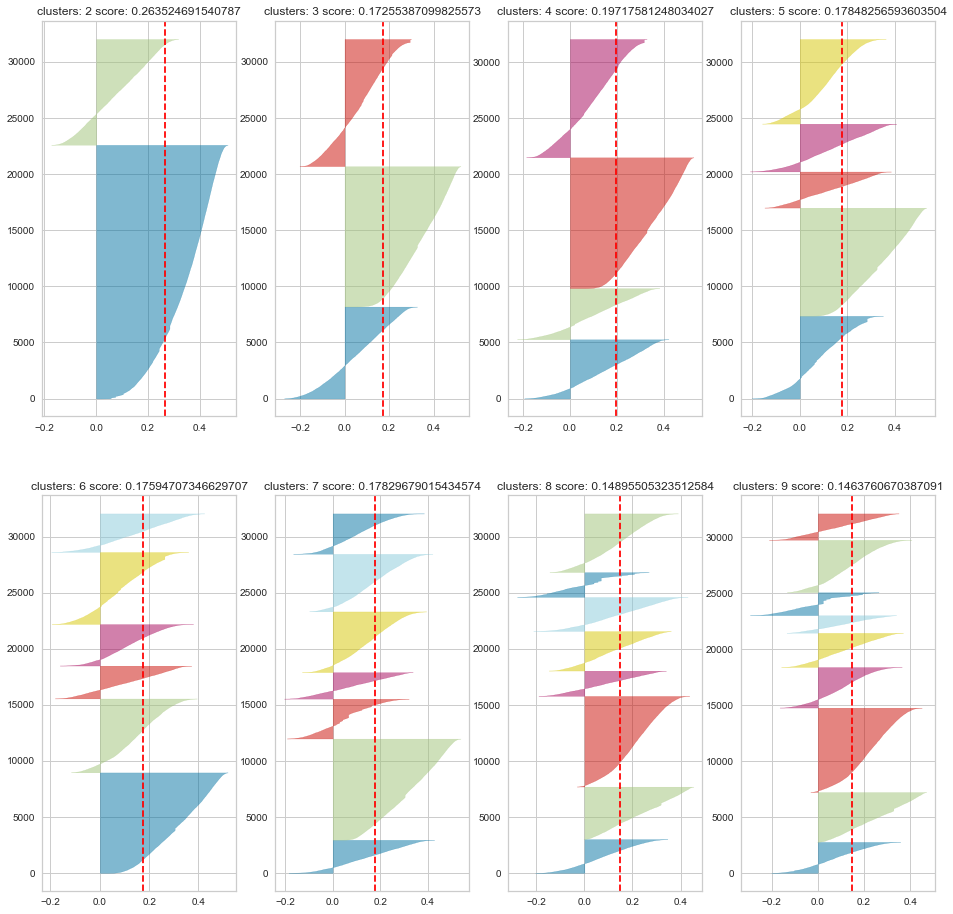

In [106]:
plt.figure(figsize=(4 * 4,  2 * 8))

scores = {}
for n_clusters in range(2,10):
    plt.subplot(2, 4, n_clusters - 1)
    kmeans = KMeans(n_clusters, random_state=42)
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
    visualizer.fit(X)
    scores[n_clusters] = visualizer.silhouette_score_
    plt.title(f'clusters: {n_clusters} score: {visualizer.silhouette_score_}')

In [108]:
sorted(scores.items(), key=lambda kv: kv[1], reverse=True)

[(2, 0.263524691540787),
 (4, 0.19717581248034027),
 (5, 0.17848256593603504),
 (7, 0.17829679015434574),
 (6, 0.17594707346629707),
 (3, 0.17255387099825573),
 (8, 0.14895505323512584),
 (9, 0.1463760670387091)]

In [109]:
vectorized_abst = vectorize_pretrained(abstr, model=glove_model)
len(vectorized_abst), len(vectorized_abst[0])

(32004, 300)

In [110]:
X=np.array(vectorized_abst)

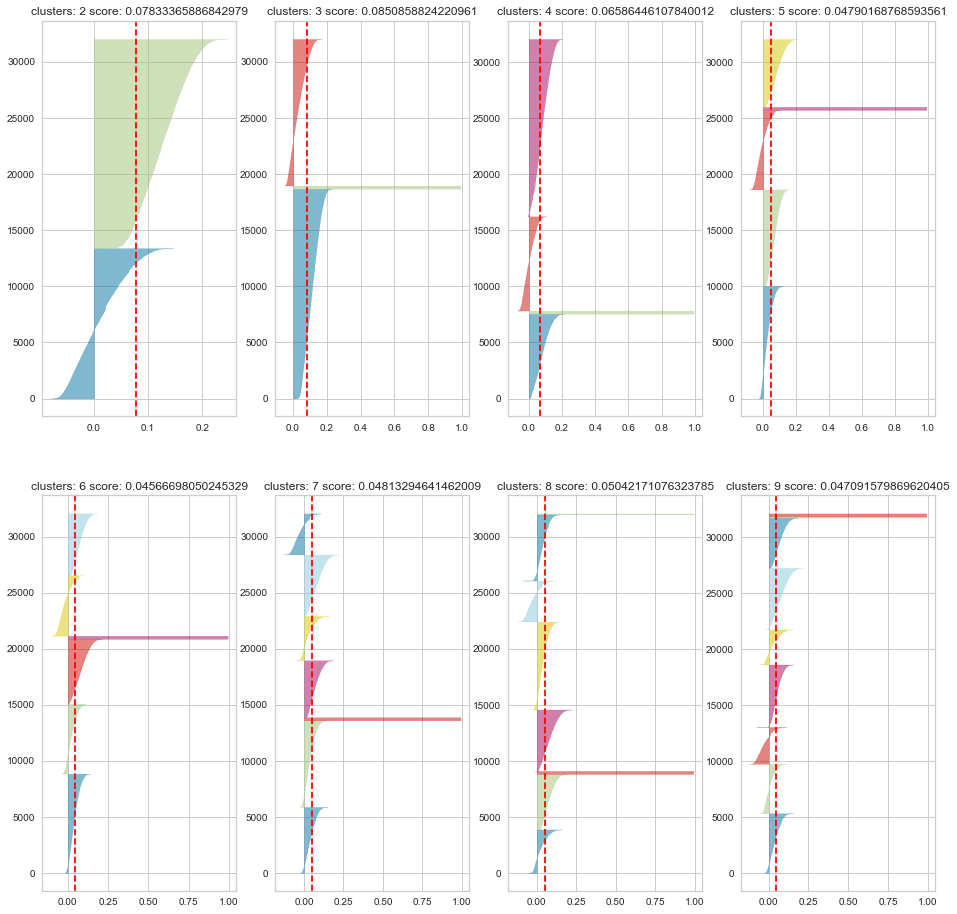

In [111]:
plt.figure(figsize=(4 * 4,  2 * 8))

scores = {}
for n_clusters in range(2,10):
    plt.subplot(2, 4, n_clusters - 1)
    kmeans = KMeans(n_clusters, random_state=42)
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
    visualizer.fit(X)
    scores[n_clusters] = visualizer.silhouette_score_
    plt.title(f'clusters: {n_clusters} score: {visualizer.silhouette_score_}')

In [112]:
sorted(scores.items(), key=lambda kv: kv[1], reverse=True)

[(3, 0.0850858824220961),
 (2, 0.07833365886842979),
 (4, 0.06586446107840012),
 (8, 0.05042171076323785),
 (7, 0.04813294641462009),
 (5, 0.04790168768593561),
 (9, 0.047091579869620405),
 (6, 0.04566698050245329)]